# TODO 
- documentation

In [1]:
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator
from xopt.generators.bayesian.bax.algorithms import GridOptimize
from xopt.evaluator import Evaluator
from xopt.generators.bayesian.bax.visualize import visualize_virtual_objective

import numpy as np
import random

import os
import math
import matplotlib.pyplot as plt

# Ignore all warnings
import warnings

warnings.filterwarnings("ignore")


os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# random seeds for reproducibility
rand_seed = 2

torch.manual_seed(rand_seed)
np.random.seed(rand_seed)  # only affects initial random observations through Xopt
random.seed(rand_seed)

In [2]:
# define variables and function objectives
vocs = VOCS(
    variables={"x0": [0, 2 * math.pi],
              },
    observables=["y1"],
)

In [3]:
# define a test function to optimize
def sin_function(input_dict):
    return {"y1": np.sin(input_dict["x0"])}

In [4]:
from bax_algorithms.pathwise.base import PathwiseOptimization
from botorch.models.model import Model, ModelList
from torch import Tensor
from typing import List
from pydantic import Field
from botorch.sampling.pathwise.posterior_samplers import draw_matheron_paths
from bax_algorithms.pathwise.optimize import DifferentialEvolution

class PathwiseMinimize(PathwiseOptimization):

    def evaluate_virtual_objective(
        self,
        model: Model,
        x: Tensor,
        bounds: Tensor,
        n_samples: int = None,
        tkwargs: dict = None,
    ) -> Tensor:
        return self.evaluate_virtual_observables(model, x, n_samples)

In [5]:
# Prepare BAX algorithm and generator options
algorithm = PathwiseMinimize(n_samples=10,
                             observable_names_ordered=["y1"],
                             optimizer = DifferentialEvolution(minimize=True)
)

# construct BAX generator
generator = BaxGenerator(vocs=vocs, algorithm=algorithm)
generator.gp_constructor.use_low_noise_prior = True

In [6]:
# construct evaluator
evaluator = Evaluator(function=sin_function)

# construct Xopt optimizer
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [7]:
# evaluate initial points
X.random_evaluate(3)

# inspect the gathered data
X.data

,x0,y1,xopt_runtime,xopt_error
0,3.543749,-0.391403,0.000014,False
1,6.120286,-0.162180,0.000004,False
2,2.829554,0.306999,0.000003,False


In [8]:
import time
for i in range(10):
    print(i)
    start=time.time()
    X.step()
    print(time.time()-start)

0
2.9982593059539795
1
2.2781975269317627
2
1.0873477458953857
3
3.0429675579071045
4
1.4721744060516357
5
1.4299216270446777
6
1.520920753479004
7
1.494680404663086
8
1.7079510688781738
9
2.7436270713806152


In [9]:
x = torch.linspace(0, 2*torch.pi, 100)
y = X.generator.algorithm.results['sample_functions_list'][0](x.reshape(-1,1))

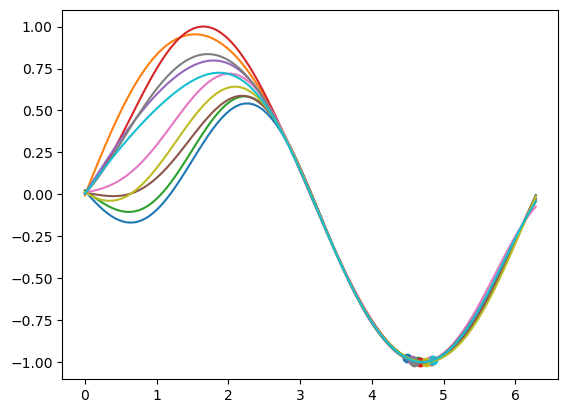

In [10]:
from matplotlib import pyplot as plt
for i in range(y.shape[0]):
    plt.plot(x,y[i].flatten().detach())
    plt.scatter(X.generator.algorithm.results['best_x'][i].flatten(), X.generator.algorithm.results['best_y'][i].detach().flatten())